In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from Constants import *

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
3


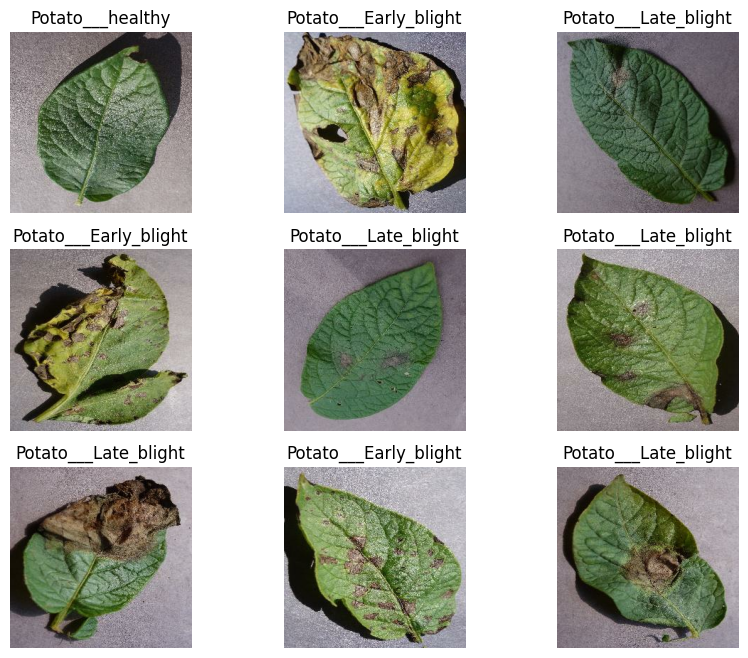

In [4]:
plt.figure(figsize = (10, 8))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [5]:
train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.15 * len(dataset)) + 1

In [6]:
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [7]:
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

In [8]:
'''def data_partitions(dataset, train_split = 0.75, test_split = 0.15, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = seed)
        
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_set = dataset.take(train_size)

    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)

    return train_set, test_set, val_set'''

'def data_partitions(dataset, train_split = 0.75, test_split = 0.15, val_split = 0.1, shuffle = True, shuffle_size = 10000):\n    dataset_size = len(dataset)\n    \n    if shuffle:\n        dataset = dataset.shuffle(shuffle_size, seed = seed)\n        \n    train_size = int(train_split * dataset_size)\n    val_size = int(val_split * dataset_size)\n\n    train_set = dataset.take(train_size)\n\n    val_set = dataset.skip(train_size).take(val_size)\n    test_set = dataset.skip(train_size).skip(val_size)\n\n    return train_set, test_set, val_set'

In [9]:
#train_set, test_set, val_set = data_partitions(dataset)

In [10]:
print(len(train_set))
print(len(test_set))
print(len(val_set))

51
11
6


In [11]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [12]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [13]:
augmented_data = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape = (image_size, image_size,
                                     3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomFlip("horizontal_and_vertical")
])

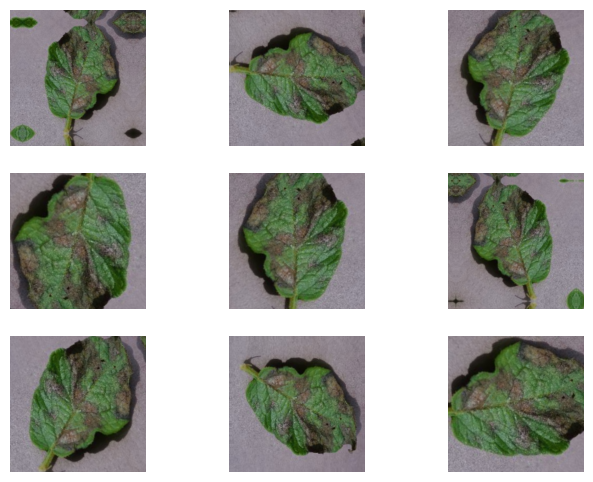

In [14]:
plt.figure(figsize = (8, 6))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = augmented_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [36]:
input_shape = (BATCH_SIZE, image_size, image_size, num_classes)

model = keras.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (32, 127, 127, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 128)       73856     
                                                      

In [40]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [41]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    epochs = 10,
                    verbose = 1
                    )

Epoch 1/10


51/51 [==============================] - 350s 7s/step - loss: 0.9486 - accuracy: 0.4810 - val_loss: 0.9339 - val_accuracy: 0.6354
Epoch 2/10
51/51 [==============================] - 291s 6s/step - loss: 0.8122 - accuracy: 0.6103 - val_loss: 0.6953 - val_accuracy: 0.7656
Epoch 3/10
51/51 [==============================] - 293s 6s/step - loss: 0.5714 - accuracy: 0.7586 - val_loss: 0.5438 - val_accuracy: 0.7917
Epoch 4/10
51/51 [==============================] - 315s 6s/step - loss: 0.4473 - accuracy: 0.8199 - val_loss: 0.2870 - val_accuracy: 0.9323
Epoch 5/10
51/51 [==============================] - 343s 7s/step - loss: 0.3893 - accuracy: 0.8493 - val_loss: 0.3023 - val_accuracy: 0.8802
Epoch 6/10
51/51 [==============================] - 341s 7s/step - loss: 0.4102 - accuracy: 0.8370 - val_loss: 0.2945 - val_accuracy: 0.9062
Epoch 7/10
51/51 [==============================] - 343s 7s/step - loss: 0.3682 - accuracy: 0.8517 - val_loss: 0.2538 - val_accuracy: 0.8802
Epoch 8/10
51/51 [======

In [42]:
loss = model.evaluate(test_set)
loss

11/11 [==============================] - 17s 2s/step - loss: 0.1994 - accuracy: 0.9116


[0.19942212104797363, 0.9115853905677795]

In [ ]:
history = history.history

In [47]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

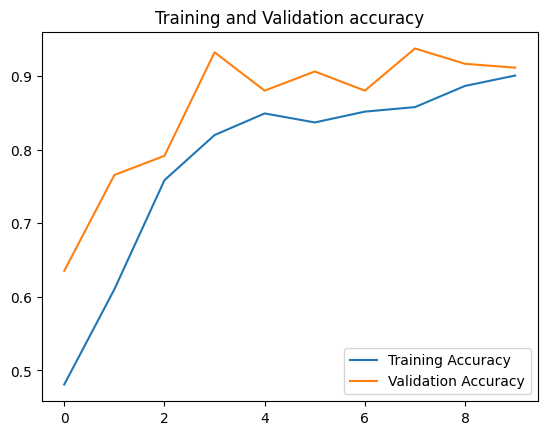

In [48]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

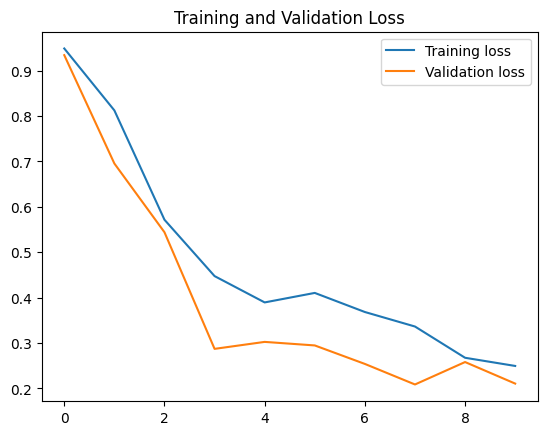

In [49]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

Image to be classified
1/1 [==============================] - 2s 2s/step
Predicted label:  Potato___healthy
Actual label: Potato___healthy


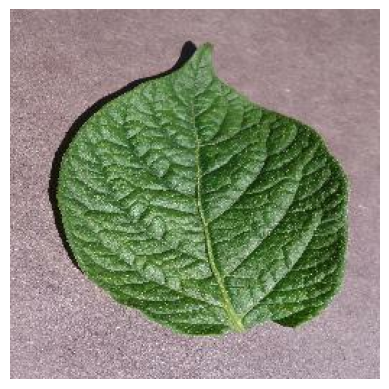

In [70]:
for images_batch, labels_batch in test_set.take(1):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    print("Image to be classified")
    plt.imshow(displayed_image)
    plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)

In [73]:
if actual == predicted:
    print("Prediction matches!")
else:
    print("Wrong prediction!")

Prediction matches!


In [60]:
def predict(model, img):
    image_array = keras.preprocessing.image.img_to_array(images[1].numpy())
    image_array = tf.expand_dims(image_array, 0)
    
    predictions = model.predict(image_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence  

1/1 [==============================] - 0s 62ms/step


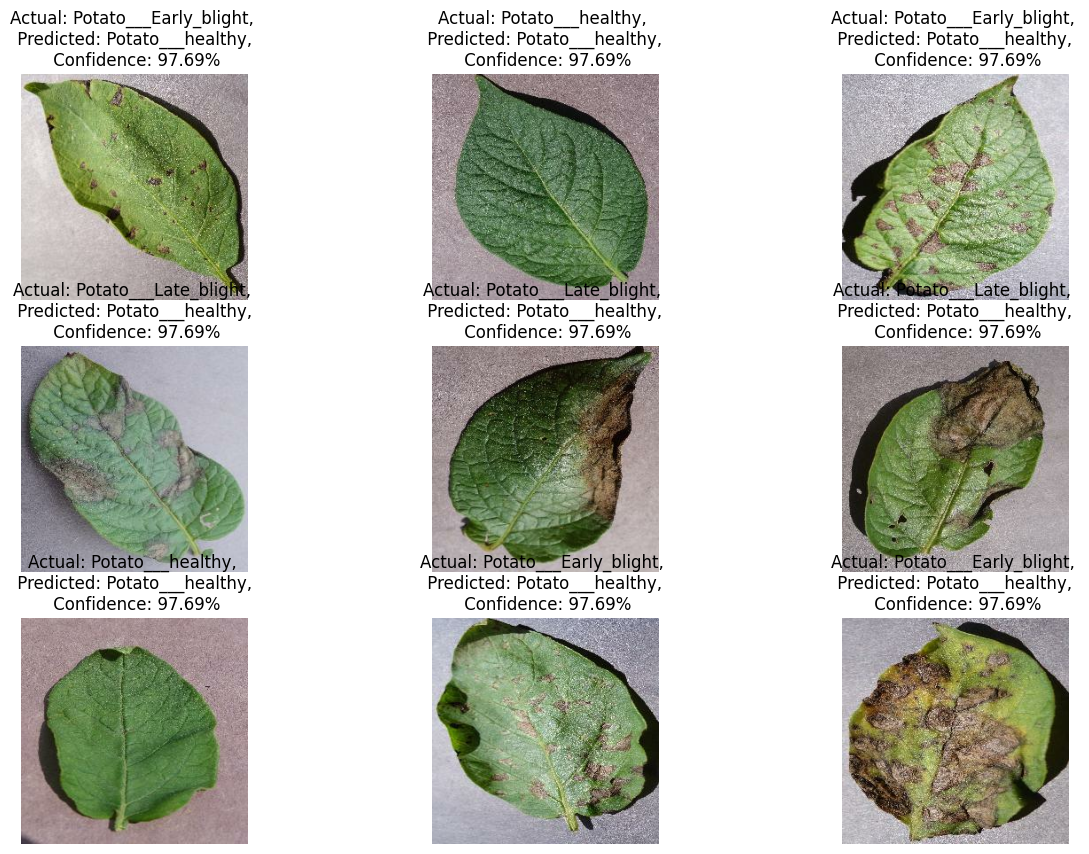

In [63]:
plt.figure(figsize = (12, 10))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        #plt.title("Actual class: {}, \n Predicted class: {}, \n Confidence: {}%", actual_class, predicted_class, confidence)
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
model_version = 1
model.save(f"../saved_models/{model_version}")

# make changes to model architecture and save it by changing the model version number

In [ ]:
# this line saves the model just by running, uncomment when new model version is to be saved
#model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
#model.save(f"../saved_models/{model_version}")